## Example 3

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
np.set_printoptions(threshold=5)
np.__version__

'1.10.1'

In [4]:
import pystan
pystan.__version__

'2.8.0.0'

In [5]:
# runstan.R
m = np.loadtxt('input/data-plate.txt', delimiter=',')
m

array([[ 1.09,  1.16,  0.63, ...,  1.54,  1.83,  2.06],
       [ 1.39,  1.85,  0.49, ...,  1.17,  1.54,  0.01],
       [-0.81,  2.24,  0.27, ...,  3.91,  2.48,  2.86],
       ..., 
       [ 3.68,  3.38,  2.48, ...,  1.89,  1.27, -0.64],
       [ 5.3 ,  5.34,  6.13, ...,  4.14,  1.57,  0.05],
       [ 1.69,  1.64,  0.42, ...,  0.68, -1.13, -0.33]])

(0, 24)

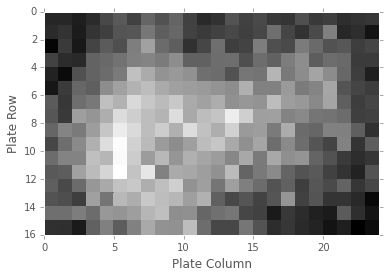

In [6]:
# fig3.R
fig, ax = plt.subplots(1, 1)
ax.pcolor(m, cmap=plt.get_cmap('gray'))
ax.set_xlabel('Plate Column')
ax.set_ylabel('Plate Row')
ax.invert_yaxis()
ax.set_xlim(0, 24)

In [7]:
T = 96
Ni, Nj = m.shape
Ni, Nj

(16, 24)

In [8]:
rownames = np.tile(np.arange(1, Ni + 1), Nj)
rownames

array([ 1,  2,  3, ..., 14, 15, 16])

In [9]:
colnames = np.repeat(np.arange(1, Nj + 1), Ni)
colnames

array([ 1,  1,  1, ..., 24, 24, 24])

In [10]:
d_melt = np.vstack([rownames, colnames, m.ravel(order='F')]).T
d_melt

array([[  1.  ,   1.  ,   1.09],
       [  2.  ,   1.  ,   1.39],
       [  3.  ,   1.  ,  -0.81],
       ..., 
       [ 14.  ,  24.  ,  -0.64],
       [ 15.  ,  24.  ,   0.05],
       [ 16.  ,  24.  ,  -0.33]])

In [11]:
d_design = np.loadtxt('input/data-plate-design.txt', delimiter=',', dtype=np.int64)
d_design

array([[88, 84, 60, ..., 53,  7, 92],
       [81, 96, 35, ..., 35, 17, 26],
       [51, 61, 51, ...,  5, 88, 56],
       ..., 
       [94, 63, 37, ..., 96, 79, 48],
       [75, 75, 59, ..., 20, 86, 50],
       [63, 33, 37, ..., 44, 26,  9]])

In [12]:
d_melt.shape

(384, 3)

In [13]:
from rpy2.robjects import r
import rpy2.robjects as robjects
import rpy2.robjects.numpy2ri as n2r

df = robjects.DataFrame({'row': n2r.py2ri(d_melt[:, 0]),
                         'col': n2r.py2ri(d_melt[:, 1]),
                         'Y': n2r.py2ri(d_melt[:, 2])})
loess_res = r.loess("Y ~ row + col", data=df, span=0.1)
vector = n2r.ri2py(loess_res.rx('fitted')[0])
smoothed = np.matrix(vector.reshape(Nj, Ni).T)
smoothed

matrix([[ 1.18836818,  1.14700081,  1.36330189, ...,  2.20204339,
          1.73759318,  1.13799464],
        [ 1.04122751,  1.00957627,  1.33377777, ...,  2.80793932,
          2.17901237,  1.41486002],
        [ 0.87202044,  1.1461162 ,  1.75785438, ...,  3.58899316,
          2.63115971,  1.62052332],
        ..., 
        [ 3.88378517,  4.17615607,  5.00510103, ...,  2.27031383,
          1.83860697,  1.22217918],
        [ 3.38767571,  3.69034242,  4.40992191, ...,  1.30283393,
          0.88063887,  0.28376363],
        [ 2.05300955,  2.27680159,  2.7974704 , ...,  0.22287274,
         -0.19677239, -0.77697027]])

In [14]:
data = dict(Ni=Ni, Nj=Nj, Y=m, T=T, T_index=d_design)

stanmodel = pystan.StanModel(file='model.stan')
fit = stanmodel.sampling(data=data, init=lambda: dict(r=smoothed, s_r=1, s_y=1, s_beta=1,
                                                      beta=np.random.normal(0, 0.1, T)),
                         iter=5200, warmup=200, thin=5, seed=1234, chains=3)
fit

Inference for Stan model: anon_model_621baec209ca334c2bc9383839ef962d.
3 chains, each with iter=5200; warmup=200; thin=5; 
post-warmup draws per chain=1000, total post-warmup draws=3000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
r[0,0]     1.08  5.7e-3   0.31   0.47   0.87   1.08    1.3   1.69   3000    1.0
r[1,0]     1.15  4.4e-3   0.24   0.68   0.98   1.14   1.31   1.62   3000   1.01
r[2,0]     1.17  4.4e-3   0.24    0.7   1.01   1.17   1.34   1.63   3000   1.01
r[3,0]     1.31  4.3e-3   0.24   0.86   1.14   1.31   1.47   1.77   3000   1.01
r[4,0]     1.47  4.3e-3   0.23   1.02   1.32   1.48   1.63   1.94   3000   1.01
r[5,0]      1.7  4.2e-3   0.23   1.25   1.54   1.69   1.85   2.14   3000   1.01
r[6,0]     2.05  4.2e-3   0.23   1.59    1.9   2.05   2.21   2.52   3000   1.01
r[7,0]      2.6  4.3e-3   0.24   2.13   2.44    2.6   2.76   3.06   3000   1.01
r[8,0]     3.21  4.4e-3   0.24   2.75   3.04   3.21   3.37   3.69   3000    1.0
r[9,0]     3

In [17]:
# runstan-post-fig4.R
# after estimation
la = fit.extract()
r_median = np.percentile(la['r'], q=50, axis=0)
r_median

array([[ 1.07893401,  1.26526672,  1.67559361, ...,  2.45301074,
         2.02202457,  1.54015281],
       [ 1.14425915,  1.45014096,  1.93297074, ...,  2.88291141,
         2.28662123,  1.67660906],
       [ 1.16696954,  1.61061632,  2.26612682, ...,  3.43184481,
         2.64128407,  1.81310352],
       ..., 
       [ 2.6423302 ,  3.79962133,  5.09686132, ...,  1.6980338 ,
         1.18679444,  0.86954809],
       [ 2.12988793,  2.92169039,  3.95397336, ...,  1.21743009,
         0.83015662,  0.5156798 ],
       [ 1.52658638,  2.07898329,  2.83214487, ...,  0.76601224,
         0.48490322,  0.20104611]])

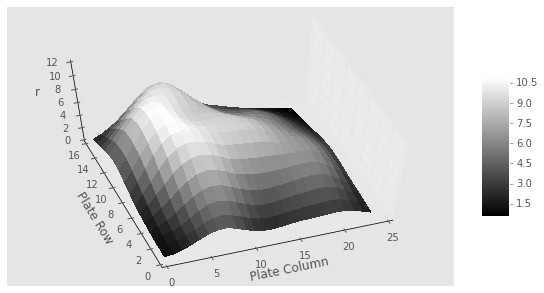

In [23]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))
ax = fig.gca(projection='3d')
X = np.arange(Nj)
Y = np.arange(Ni)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, r_median, rstride=1, cstride=1, cmap=plt.get_cmap('gray'),
        linewidth=0, antialiased=False)
ax.set_xlabel('Plate Column')
ax.set_ylabel('Plate Row')
ax.set_zlabel('r')

ax.view_init(elev=60., azim=250)
fig.colorbar(surf, shrink=0.5, aspect=5);

In [24]:
qua = np.percentile(la['beta'], q=[10, 50, 90], axis=0)
qua

array([[-1.66149234,  0.5164041 ,  1.5341488 , ...,  1.12987529,
        -0.68794997,  0.1275614 ],
       [-1.39144346,  0.79880298,  1.80272396, ...,  1.41782357,
        -0.42266128,  0.3985145 ],
       [-1.11704502,  1.07756543,  2.06084856, ...,  1.69161406,
        -0.1470554 ,  0.66226812]])

In [25]:
mean_Y = np.array([np.mean(m[d_design == i]) - np.mean(m) for i in range(1, T + 1)])
mean_Y

array([-2.19348958,  0.67651042,  2.82651042, ...,  1.40651042,
       -0.10598958, -0.93098958])

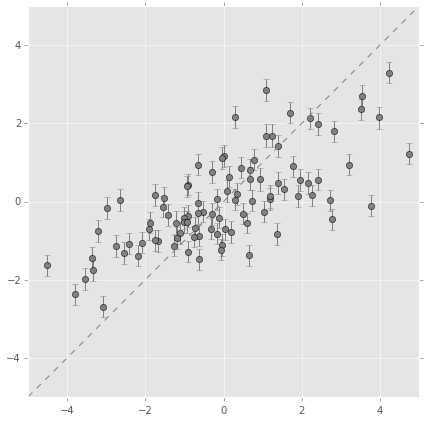

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(7, 7))
ax.errorbar(mean_Y, y=qua[1, :], yerr=[qua[1, :] - qua[0, :], qua[2, :] - qua[1, :]], fmt='o', 
           color='gray')
ax.plot(np.arange(-5, 6), np.arange(-5, 6), color='gray', linestyle='dashed')
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5);